<h2><b>Bean Disease Classification Model</b></h2>

<h2><b>Importing necessary Libraries and Modules</b></h2>

In [1]:
import keras
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3


In [2]:
# Define data directories
train_dir = "Beans_diseases_datasetT2/train"
test_dir = "Beans_diseases_datasetT2/test"


<h2><b>Data Visualization</b></h2>

Found 792 files belonging to 3 classes.


2024-06-20 10:13:06.908547: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-20 10:13:06.908582: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-20 10:13:06.908591: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-20 10:13:06.908629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-20 10:13:06.908644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


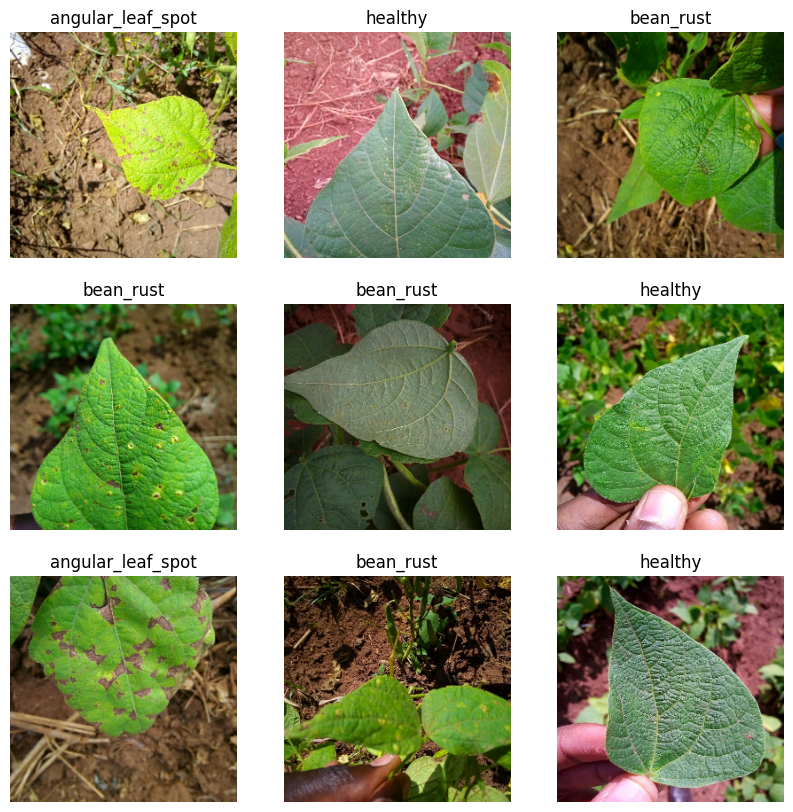

In [3]:
class_names = ["angular_leaf_spot", "bean_rust", "healthy"]
train_ds = tf.keras.utils.image_dataset_from_directory("Beans_diseases_datasetT/train")
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32
num_classes = 3


<h2><b>Transfer Learning</b></h2>

In [5]:
# Load MobileNetV2 base model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, num_classes))

In [6]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

<h2><b>Create Model</b></h2>

In [7]:
# Create model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

<h2><b>Compile Model</b></h2>

In [8]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    "Beans_diseases_datasetT2/train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 792 images belonging to 3 classes.


In [11]:
validation_generator = test_datagen.flow_from_directory(
    "Beans_diseases_datasetT2/validation",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 99 images belonging to 3 classes.


<h2><b>Train Model</b></h2>

In [12]:
# Train model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=64,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size)
training_time = time.time() - start_time

Epoch 1/64


2024-06-20 10:13:31.436861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-20 10:13:31.501985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


24/24 [==============================] - 7s 249ms/step - loss: 1.1607 - accuracy: 0.5997 - val_loss: 0.6398 - val_accuracy: 0.6970
Epoch 2/64
24/24 [==============================] - 6s 226ms/step - loss: 0.4640 - accuracy: 0.8043 - val_loss: 0.4934 - val_accuracy: 0.8182
Epoch 3/64
24/24 [==============================] - 6s 220ms/step - loss: 0.3219 - accuracy: 0.8699 - val_loss: 0.4481 - val_accuracy: 0.8182
Epoch 4/64
24/24 [==============================] - 6s 223ms/step - loss: 0.2751 - accuracy: 0.8763 - val_loss: 0.4315 - val_accuracy: 0.8283
Epoch 5/64
24/24 [==============================] - 6s 221ms/step - loss: 0.2194 - accuracy: 0.9331 - val_loss: 0.3720 - val_accuracy: 0.8485
Epoch 6/64
24/24 [==============================] - 5s 218ms/step - loss: 0.2023 - accuracy: 0.9255 - val_loss: 0.3573 - val_accuracy: 0.8485
Epoch 7/64
24/24 [==============================] - 5s 218ms/step - loss: 0.2226 - accuracy: 0.9129 - val_loss: 0.3405 - val_accuracy: 0.8687
Epoch 8/64
24/24 

<h2><b>Evaluate Model</b></h2>

In [34]:
# Evaluate model
test_generator = test_datagen.flow_from_directory(
    "Beans_diseases_datasetT2/test",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 99 images belonging to 3 classes.


In [35]:
# Print model Summary
#model.summary()

In [36]:
y_true = test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

4/4 [==============================] - 1s 113ms/step


In [37]:
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("precision:", precision)
print("Traininig Time: ", training_time)

Accuracy: 0.9292929292929293
Recall: 0.9292929292929293
precision: 0.9389140271493213
Traininig Time:  356.8796319961548


In [38]:
# Save the model
#model.save('my_model')

<h2><b>Confusion Matrix</b></h2>

In [39]:
# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[26  6  1]
 [ 0 33  0]
 [ 0  0 33]]


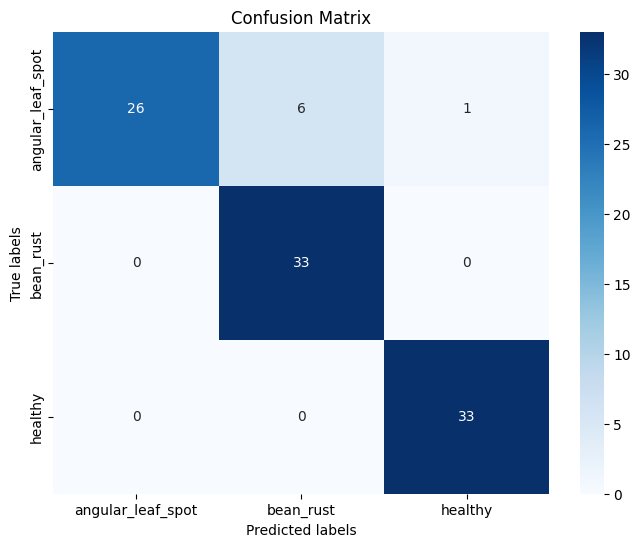

In [40]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

<h2><b>Classification Report</b></h2>

In [41]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       1.00      0.79      0.88        33
        bean_rust       0.85      1.00      0.92        33
          healthy       0.97      1.00      0.99        33

         accuracy                           0.93        99
        macro avg       0.94      0.93      0.93        99
     weighted avg       0.94      0.93      0.93        99



<h2><b>Accuracy Graph</b></h2>

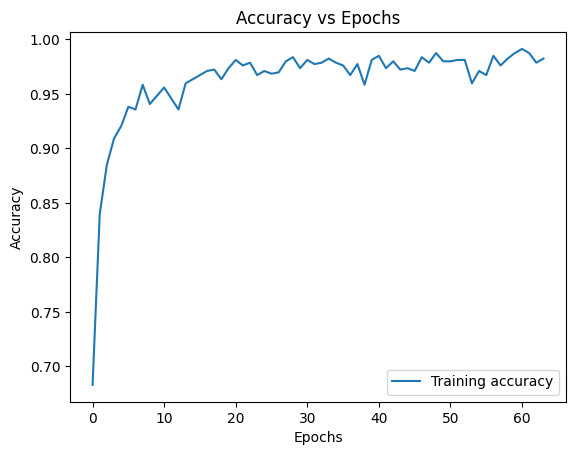

In [42]:
# Plotting accuracy vs epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

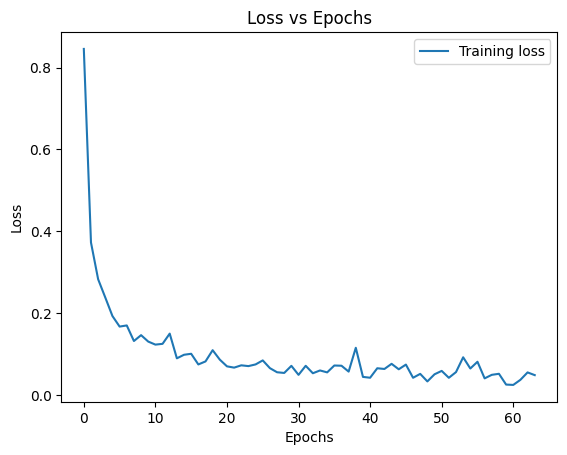

In [43]:
# Plotting loss vs epochs
plt.plot(history.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

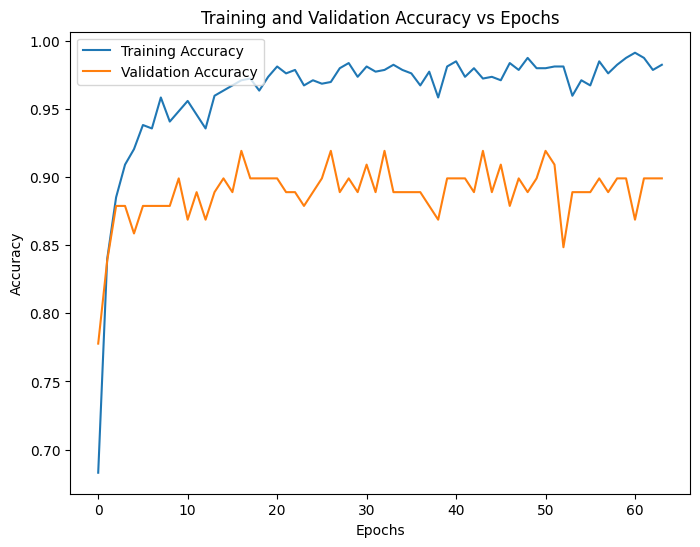

In [44]:
# Plot testing accuracy vs epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

<h2><b>Save current Model and Loading another model for prediction</b></h2>

<h2><b>Testing Model Performance</b></h2>

Found 99 files belonging to 3 classes.


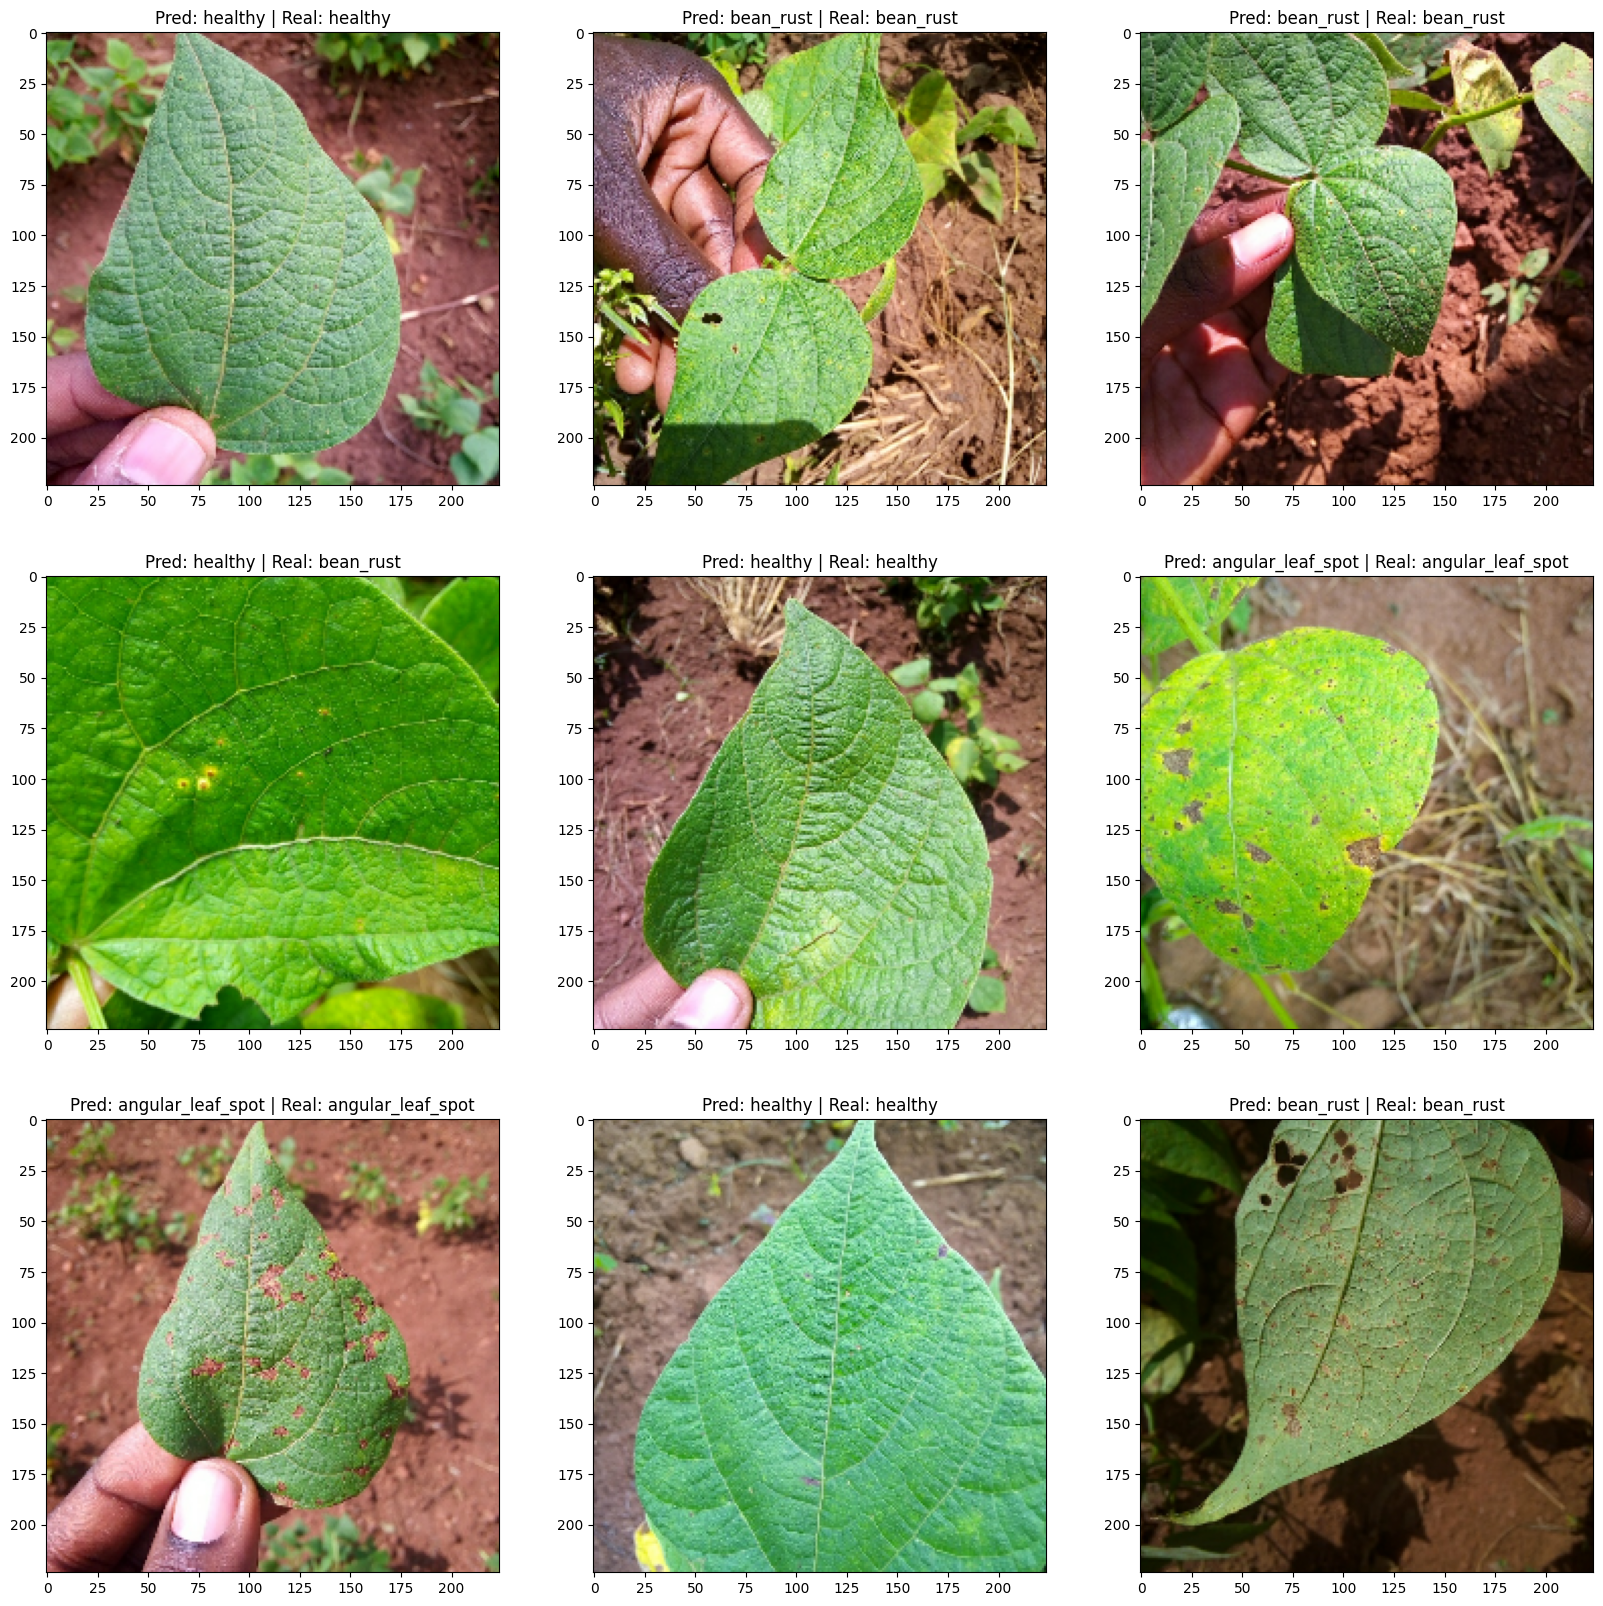

In [26]:
import numpy
# Load the entire model
loaded_model = tf.keras.models.load_model('my_model')
#test_ds = tf.keras.utils.image_dataset_from_directory("Beans_diseases_dataset/test")
test_ds = tf.keras.utils.image_dataset_from_directory(
    "Beans_diseases_datasetT/test",
    image_size = (img_width, img_height),
    batch_size = batch_size
)
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
  classifications = loaded_model(images)
  #classifications = loaded_model(images)
  # print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    class_names = test_ds.class_names
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]]) 

<h2><b>Converting our Model to Tensorflow_Lite Model for Android APP</b></h2>

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/_k/z_6c367d4vz_krzk6fzvyrd00000gn/T/tmp18nbkk36/assets


INFO:tensorflow:Assets written to: /var/folders/_k/z_6c367d4vz_krzk6fzvyrd00000gn/T/tmp18nbkk36/assets
2024-05-13 10:45:25.579079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-13 10:45:25.579095: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-13 10:45:25.579446: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/_k/z_6c367d4vz_krzk6fzvyrd00000gn/T/tmp18nbkk36
2024-05-13 10:45:25.594337: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-13 10:45:25.594352: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/_k/z_6c367d4vz_krzk6fzvyrd00000gn/T/tmp18nbkk36
2024-05-13 10:45:25.625411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-05-13 10:45:25.636522: I tensorflow/cc/saved_model/load

<h2><b>Done!</b></h2>